# Goals

* Create a tiledb-soma db for the Tahoe-100 dataset
* Description of the [metadata](https://docs.google.com/spreadsheets/d/18lu5agCNbgWsjZ9K05Mf65z1RseoFqsi/edit?usp=sharing&ouid=103963277960448548043&rtpof=true&sd=true)

# Vars

In [2]:
work_dir = '/processed_datasets/scRecount/tahoe'

# Init

In [3]:
import os
from glob import glob
import pandas as pd
import tiledbsoma
import tiledbsoma.io
import scanpy as sc
import numpy as np
import plotnine as pn

In [4]:
pn.theme_set(pn.theme_bw())

In [5]:
db_uri = os.path.join(work_dir, 'tiledb-soma')
#db_uri = os.path.join(work_dir, 'tiledb-soma-mini')
db_uri

'/processed_datasets/scRecount/tahoe/tiledb-soma'

# Create

In [5]:
# list all *.h5ad.gz files in the work directory
files = sorted(glob(os.path.join(work_dir, '*.h5ad.gz')))
files

['/processed_datasets/scRecount/tahoe/plate10_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate11_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate12_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate13_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate14_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate1_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate2_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate3_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate4_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate5_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate6_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate7_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate8_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate9_filtered.h5ad.gz']

> Ran via tmux to prevent disconnection

```bash
./scripts/tiledb-loader-tahoe.py \
  --h5ad-ext h5ad.gz \
  --db-uri /processed_datasets/scRecount/tahoe/tiledb-soma \
  /processed_datasets/scRecount/tahoe/ \
  > tiledb-loader-tahoe.log 2>&1 
```

In [6]:
adata = sc.read_h5ad('/processed_datasets/scRecount/tahoe/plate3_filtered.h5ad.gz', backed='r')
adata.obs

,sample,species,gene_count,tscp_count,mread_count,bc1_wind,bc2_wind,bc3_wind,bc1_well,bc2_well,...,DIFF.LLK.SNG.DBL,sublibrary,BARCODE,pcnt_mito,S_score,G2M_score,phase,cell_line_orig,pass_filter,cell_name
BARCODE_SUB_LIB_ID,,,,,,,,,,,,,,,,,,,,,
01_001_117-lib_1009,smp_1687,hg38,1110,1404,1655,1,1,117,A1,A1,...,-1.70,lib_1009,01_001_117,0.021368,0.011573,0.188462,G2M,CVCL_1693,full,SHP-77
01_001_122-lib_1009,smp_1687,hg38,1011,1324,1577,1,1,122,A1,A1,...,2.55,lib_1009,01_001_122,0.026435,-0.095618,-0.104762,G1,CVCL_1495,full,NCI-H1792
01_001_172-lib_1009,smp_1687,hg38,835,1042,1240,1,1,172,A1,A1,...,1.02,lib_1009,01_001_172,0.016315,-0.012047,0.015018,G2M,CVCL_0399,full,LoVo
01_002_058-lib_1009,smp_1687,hg38,754,902,1040,1,2,58,A1,A2,...,-0.99,lib_1009,01_002_058,0.016630,-0.020015,-0.076190,G1,CVCL_1056,full,A498
01_002_063-lib_1009,smp_1687,hg38,1546,2288,2695,1,2,63,A1,A2,...,-0.81,lib_1009,01_002_063,0.023601,0.027224,0.035348,G2M,CVCL_0480,full,PANC-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96_186_033-lib_2604,smp_1782,hg38,1707,2659,3048,96,186,33,H12,p2.H6,...,2.63,lib_2604,96_186_033,0.055660,-0.040030,0.015090,G2M,CVCL_0480,full,PANC-1
96_186_095-lib_2604,smp_1782,hg38,796,1052,1237,96,186,95,H12,p2.H6,...,0.22,lib_2604,96_186_095,0.088403,-0.004269,0.144461,G2M,CVCL_0371,full,KATO III
96_186_119-lib_2604,smp_1782,hg38,713,921,1071,96,186,119,H12,p2.H6,...,0.64,lib_2604,96_186_119,0.058632,-0.031967,-0.004601,G1,CVCL_1239,full,H4


# Summary

In [6]:
# get colnames
with tiledbsoma.open(db_uri) as exp:
    print(exp.obs.schema)

soma_joinid: int64 not null
BARCODE_SUB_LIB_ID: large_string
sample: dictionary<values=string, indices=int32, ordered=0>
species: dictionary<values=string, indices=int32, ordered=0>
gene_count: int64
tscp_count: int64
mread_count: int64
bc1_wind: int64
bc2_wind: int64
bc3_wind: int64
bc1_well: dictionary<values=string, indices=int32, ordered=0>
bc2_well: dictionary<values=string, indices=int32, ordered=0>
bc3_well: dictionary<values=string, indices=int32, ordered=0>
id: dictionary<values=string, indices=int32, ordered=0>
drugname_drugconc: dictionary<values=string, indices=int32, ordered=0>
drug: dictionary<values=string, indices=int32, ordered=0>
INT_ID: double
NUM.SNPS: double
NUM.READS: double
demuxlet_call: dictionary<values=string, indices=int32, ordered=0>
BEST.GUESS: dictionary<values=string, indices=int32, ordered=0>
BEST.LLK: double
NEXT.GUESS: dictionary<values=string, indices=int32, ordered=0>
NEXT.LLK: double
DIFF.LLK.BEST.NEXT: double
BEST.POSTERIOR: double
SNG.POSTERIOR: 

## Obs

In [7]:
# obs per sample
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .group_by(['sample'])
        .aggregate([
            ([], 'count_all'),
        ])
        .sort_by([("count_all", "descending")])
        .to_pandas()
    )
print(df.shape)
df.head()

(1344, 2)


,sample,count_all
0,smp_2553,215364
1,smp_2643,202116
2,smp_2177,196600
3,smp_2613,195537
4,smp_2638,192968


In [8]:
# total obs
df["count_all"].sum()

100648790

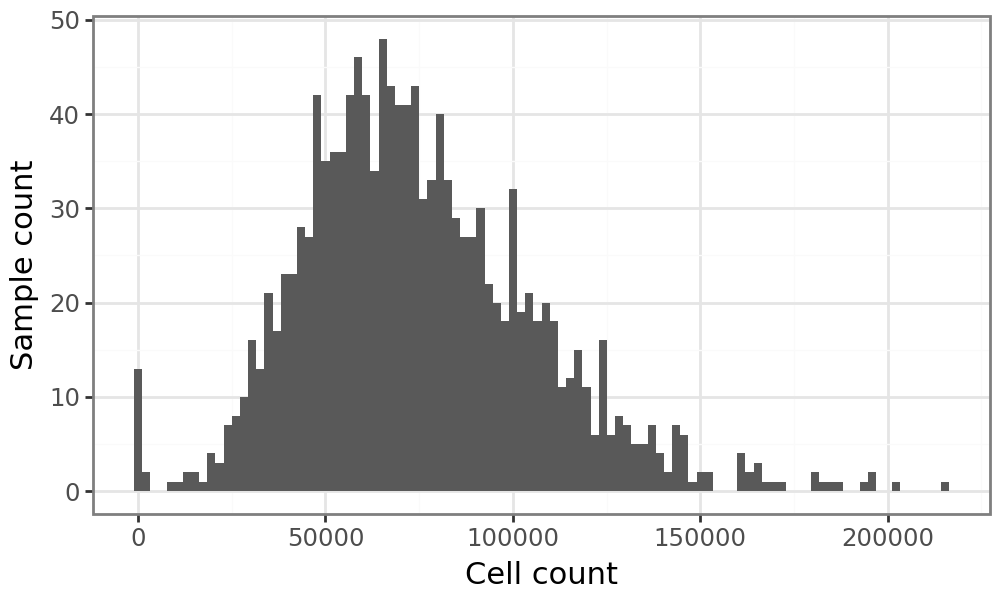

In [9]:
# plot cells per sample
p = (
    pn.ggplot(df, pn.aes(x="count_all")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Cell count", y="Sample count") +
    pn.theme(figure_size=(5,3))
    )
p

In [10]:
# cells per drug
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["drug"])
        .concat()
        .group_by(["drug"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(380, 2)


,drug,count_all
0,8-Hydroxyquinoline,303241
1,Chlorhexidine (diacetate),428705
2,Trifluridine,272488
3,Berbamine,449664
4,Retinoic acid,313463


In [11]:
# add total count by drug
top_drugs = df.sort_values('count_all', ascending=False)["drug"].unique()[:30]
df = df[df["drug"].isin(top_drugs)]
df

,drug,count_all
1,Chlorhexidine (diacetate),428705
3,Berbamine,449664
25,Quinestrol,388456
79,Goserelin (acetate),364591
83,Artesunate,381197
92,Clonidine (hydrochloride),430927
93,Adagrasib,1504078
94,DMSO_TF,2330156
97,Everolimus,378851
101,Gemcitabine,397331


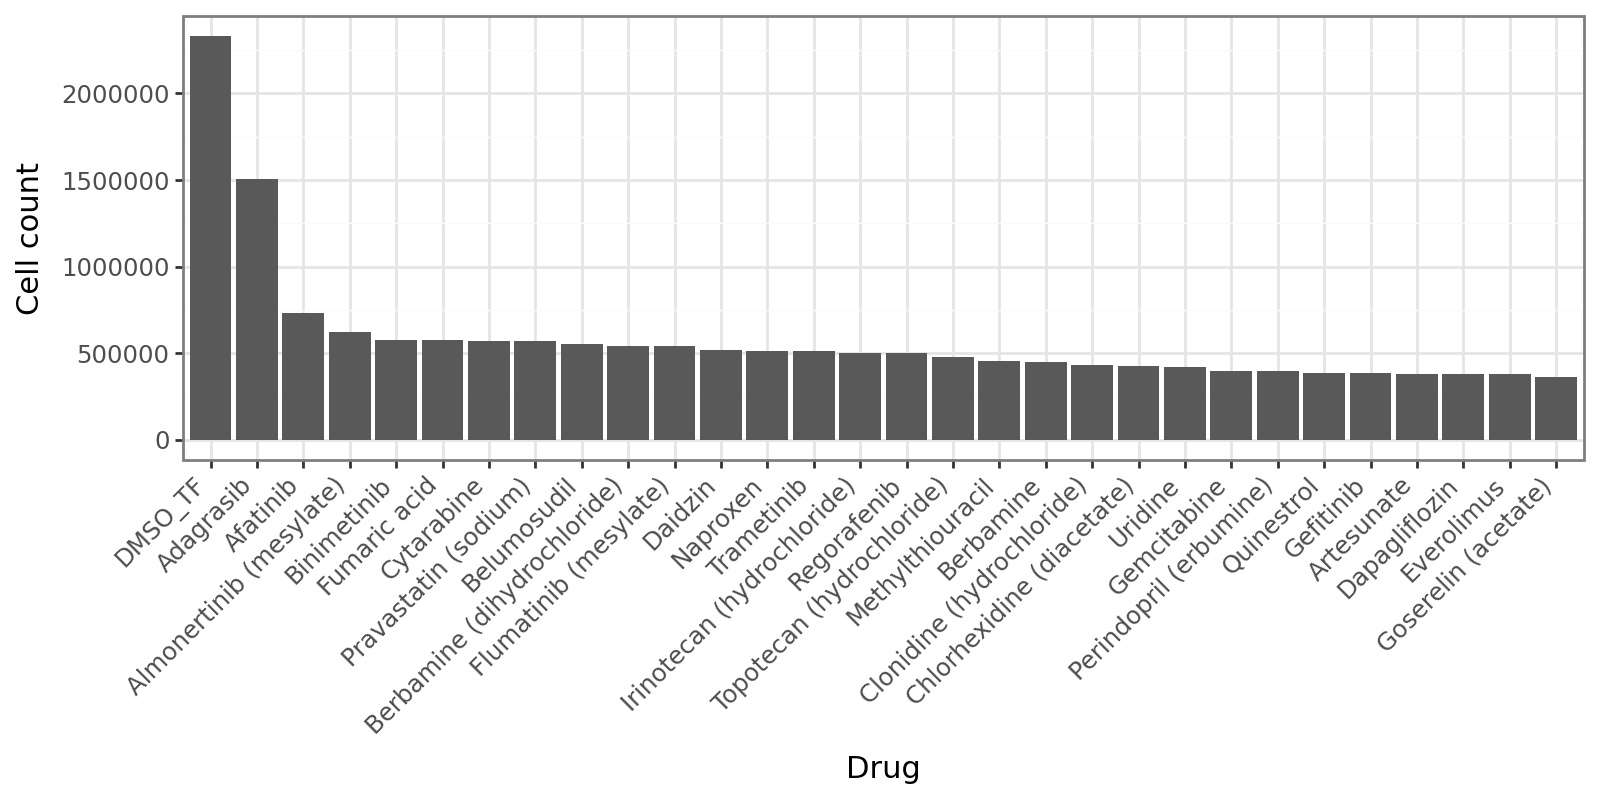

In [12]:
# plot cells per drug
df['drug'] = pd.Categorical(df['drug'], categories=df.sort_values('count_all', ascending=False)['drug'].unique().tolist(), ordered=True)
p = (
    pn.ggplot(df, pn.aes(x="drug", y="count_all")) + 
    pn.geom_col() +
    pn.labs(x="Drug", y="Cell count") +
    pn.theme(
        figure_size=(8,4),
        axis_text_x=pn.element_text(angle=45, hjust=1)
    ))
p

In [13]:
# cells per drug and cell name
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["drug", "cell_name"])
        .concat()
        .group_by(["drug", "cell_name"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(19000, 3)


,drug,cell_name,count_all
0,8-Hydroxyquinoline,KATO III,7251
1,8-Hydroxyquinoline,SW 900,5009
2,8-Hydroxyquinoline,C32,7115
3,8-Hydroxyquinoline,PANC-1,10204
4,8-Hydroxyquinoline,A549,8987


In [14]:
# add total count by drug
df["total_count"] = df.groupby("drug")["count_all"].transform("sum")
top_drugs = df.sort_values('total_count', ascending=False)["drug"].unique()[:10]
df = df[df["drug"].isin(top_drugs)]
df

/tmp/ipykernel_3112763/1395555395.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,drug,cell_name,count_all,total_count
4375,Adagrasib,Hs 766T,42742,1504078
4376,Adagrasib,HT-29,34268,1504078
4377,Adagrasib,NCI-H460,88031,1504078
4378,Adagrasib,HEC-1-A,38596,1504078
4379,Adagrasib,SW 900,27257,1504078
...,...,...,...,...
13700,Cytarabine,NCI-H596,148,569615
13735,Fumaric acid,NCI-H596,163,574017
13767,Almonertinib (mesylate),NCI-H596,170,622410
13775,Cytarabine,NCI-H2122,183,569615


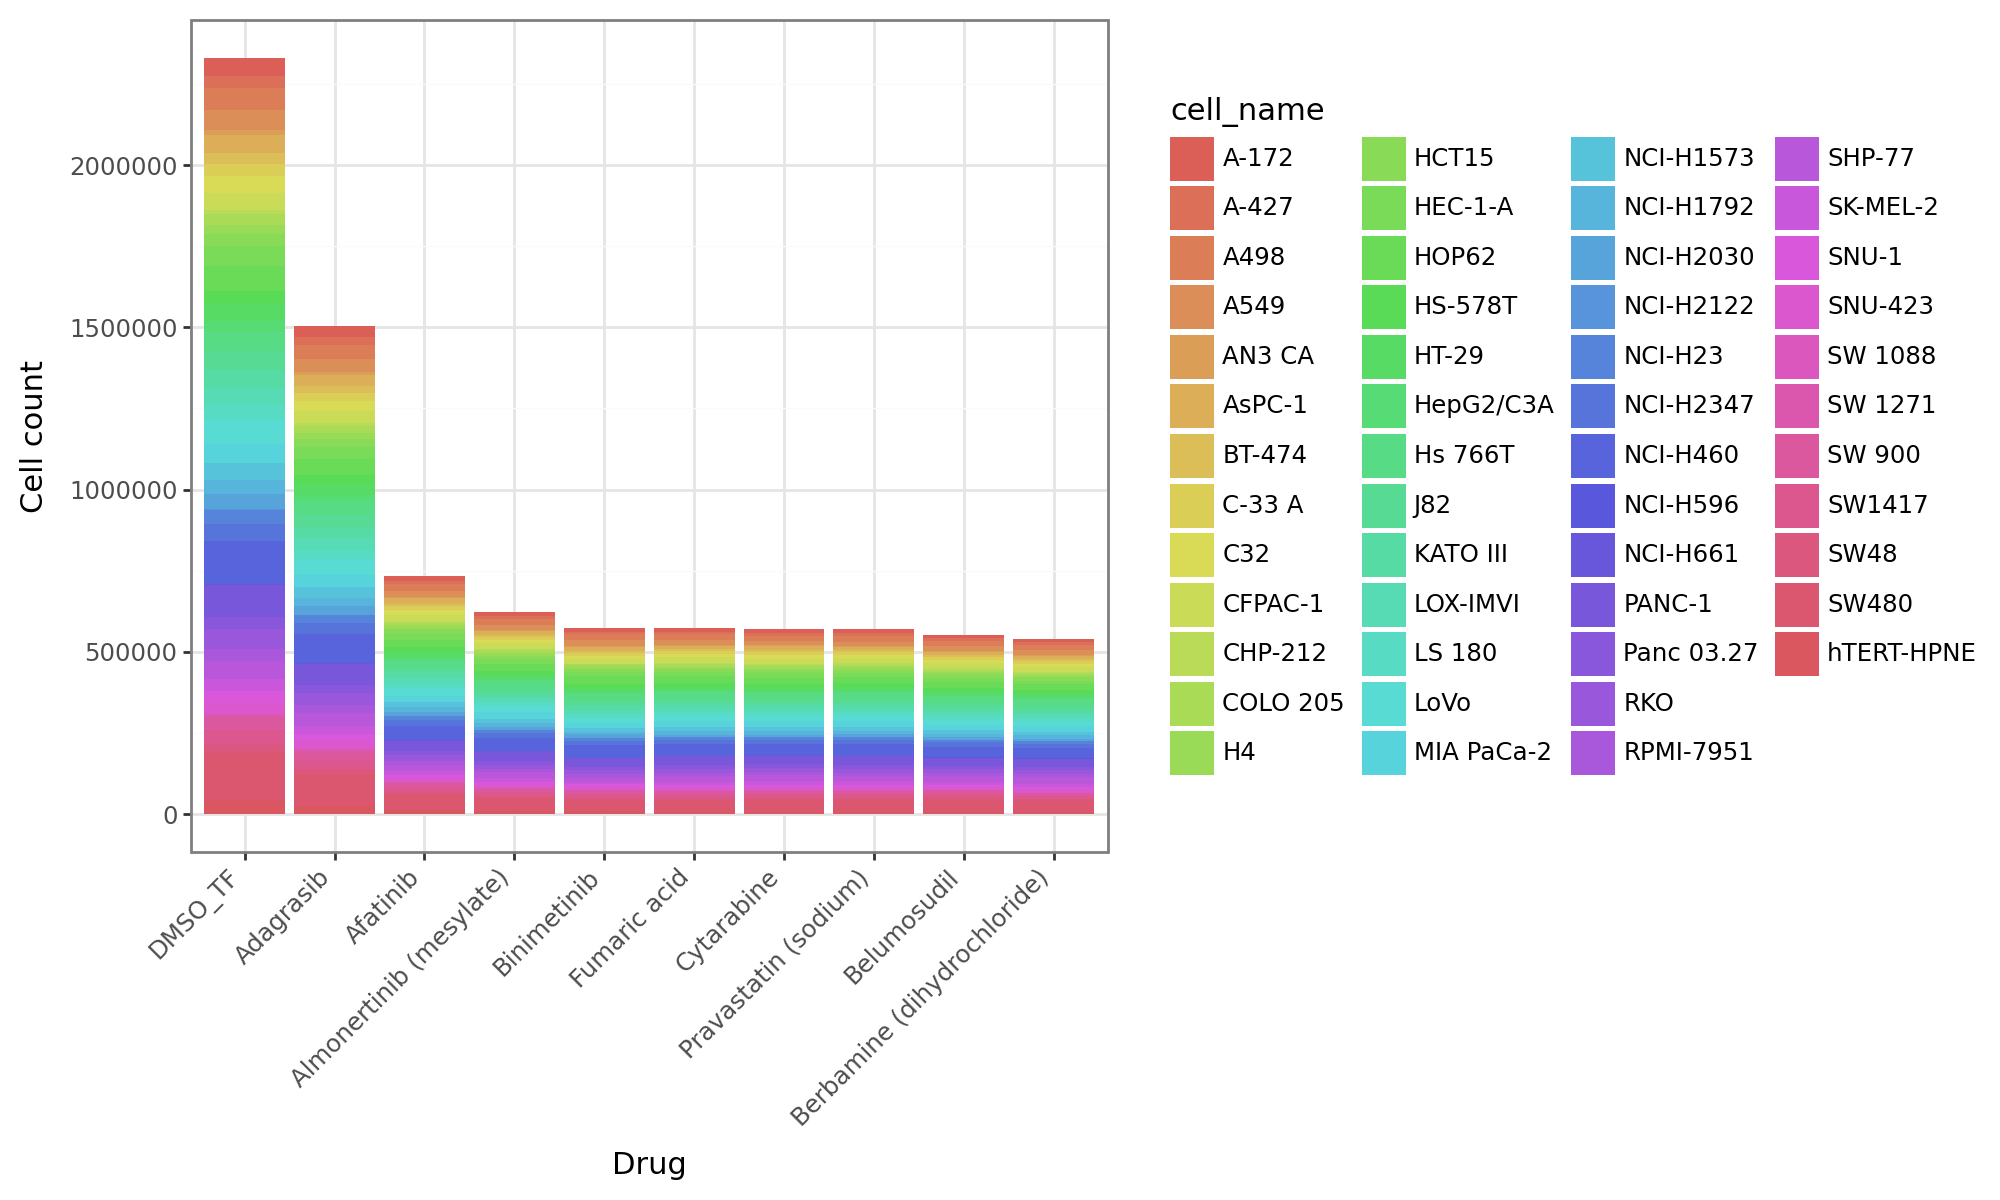

In [15]:
# plot cells per drug
df['drug'] = pd.Categorical(df['drug'], categories=df.sort_values('total_count', ascending=False)['drug'].unique().tolist(), ordered=True)
p = (
    pn.ggplot(df, pn.aes(x="drug", y="count_all", fill="cell_name")) + 
    pn.geom_col() +
    pn.labs(x="Drug", y="Cell count") +
    pn.theme(
        figure_size=(10,6),
        axis_text_x=pn.element_text(angle=45, hjust=1)
    ))
p

In [16]:
# cells per cell line/name
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["cell_line", "cell_name"])
        .concat()
        .group_by(["cell_line", "cell_name"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(50, 3)


,cell_line,cell_name,count_all
0,CVCL_0371,KATO III,2332035
1,CVCL_1731,SW 900,1791184
2,CVCL_1097,C32,2098357
3,CVCL_0480,PANC-1,4170586
4,CVCL_0023,A549,2664482


In [17]:
# cells per cell line/name
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["cell_line", "cell_name", "drug"])
        .concat()
        .group_by(["cell_line", "cell_name", "drug"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(19000, 4)


,cell_line,cell_name,drug,count_all
0,CVCL_0399,LoVo,Bimatoprost,9290
1,CVCL_1666,RPMI-7951,Bimatoprost,3958
2,CVCL_1119,CFPAC-1,Bimatoprost,5478
3,CVCL_0546,SW480,Bimatoprost,13800
4,CVCL_0152,AsPC-1,Bimatoprost,7602


In [18]:
# cells per phase
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["phase"])
        .concat()
        .group_by(["phase"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(3, 2)


,phase,count_all
0,G1,62969737
1,G2M,29455730
2,S,8223323


In [19]:
# cells per phase
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["pass_filter"])
        .concat()
        .group_by(["pass_filter"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(2, 2)


,pass_filter,count_all
0,full,95624334
1,minimal,5024456


### Transcripts

In [14]:
# transcripts per cell
with tiledbsoma.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["tscp_count"])
        .concat()
        #.slice(0,5e7)
        .to_pandas()
    )
print(df.shape)
df.head()

(100648790, 1)


,tscp_count
0,1650
1,1748
2,1285
3,2946
4,969


In [11]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df["tscp_count"].describe())

count   100648790
mean         2373
std          2093
min           161
25%          1228
50%          1825
75%          2809
max        235188
Name: tscp_count, dtype: float64


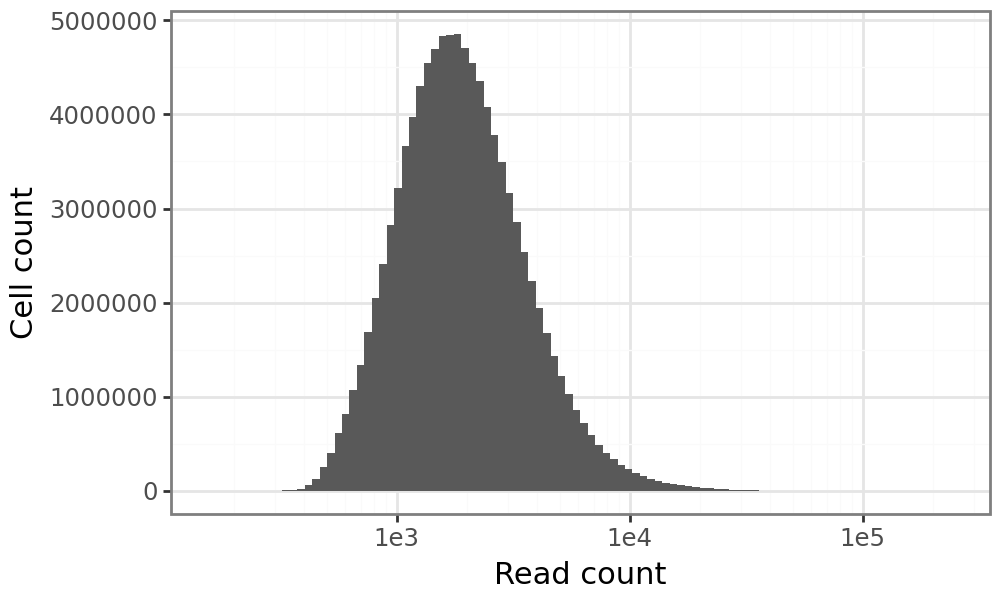

In [12]:
# plot transcripts per cell (barcode)
p = (
    pn.ggplot(df, pn.aes(x="tscp_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="Read count", y="Cell count") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

In [25]:
# gene count per cell
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["gene_count"])
        .concat()
        .to_pandas()
    )
print(df.shape)
df.head()

(100648790, 1)


,gene_count
0,1154
1,1132
2,916
3,1857
4,731


In [26]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df["gene_count"].describe())

count   100648790
mean         1451
std           812
min           115
25%           898
50%          1255
75%          1776
max         14153
Name: gene_count, dtype: float64


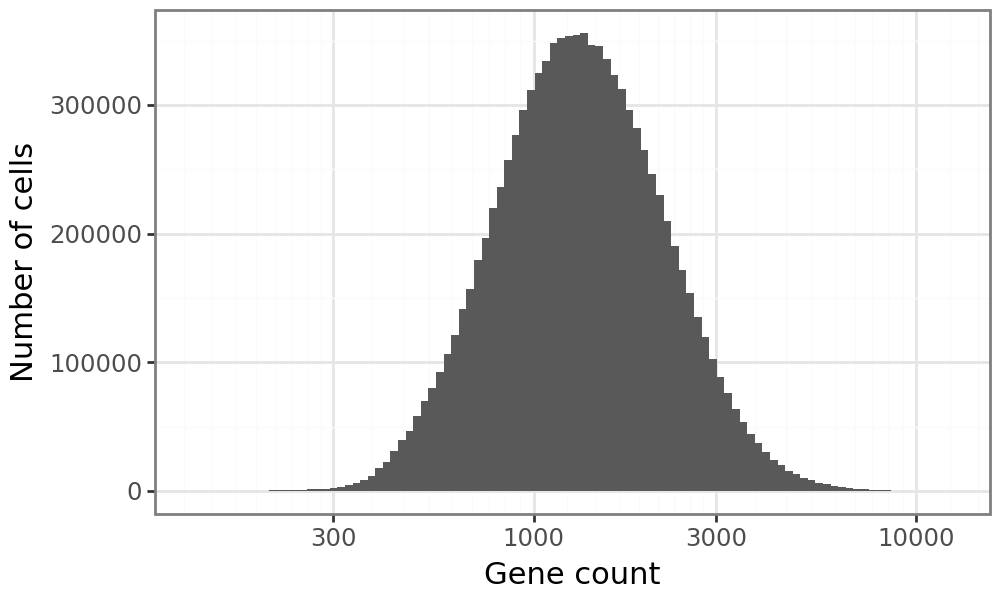

In [16]:
# plot reads per gene (barcode)
p = (
    pn.ggplot(df, pn.aes(x="gene_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="Gene count", y="Number of cells") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

## Variables

In [18]:
# get colnames
with tiledbsoma.open(db_uri) as exp:
    print(exp.ms["RNA"].var.schema)

soma_joinid: int64 not null
gene_name: large_string
var_id: large_string


In [10]:
# read in the var level data
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.ms["RNA"]
        .var.read(column_names=["soma_joinid", "var_id"])
        .concat()
        .to_pandas()
    )
df

,soma_joinid,var_id
0,0,TSPAN6
1,1,TNMD
2,2,DPM1
3,3,SCYL3
4,4,C1orf112
...,...,...
62705,62705,ENSG00000291313
62706,62706,ENSG00000291314
62707,62707,ENSG00000291315
62708,62708,ENSG00000291316


#### Convert gene names to Ensembl IDs

In [19]:
import sys
import requests

def convert_to_ensembl(genes: list, species: str="human") -> list:
    """
    Convert gene symbols to ensembl ids.
    Args:
        genes: list of gene symbols
        species: species name (default: human)
    Returns:
        list of ensembl ids
    """
    species_map = {"human": "homo_sapiens"} #, "mouse": "mus_musculus"}
    species = species_map.get(species.lower(), species)

    results = []
    for i,gene in enumerate(genes, 1):
        if i % 100 == 0:
            print(f"Processed {i} genes...", file=sys.stderr)

        # store already converted
        if gene.startswith("ENSG"):
            results.append(gene)
            continue
    
        # call api
        url = f"https://rest.ensembl.org/xrefs/symbol/{species}/{gene}?content-type=application/json"
        response = requests.get(url)
    
        if response.ok:
            data = response.json()
            if data:
                results.append(data[0]["id"])
    return results

# test
genes = ["TSPAN6", "ENSG00000291313", "BRCA1", "GAPDH"]
convert_to_ensembl(genes)

['ENSG00000000003', 'ENSG00000291313', 'ENSG00000012048', 'ENSG00000111640']

In [20]:
# convert gene names 
x = convert_to_ensembl(df["var_id"].tolist()[:300])

Processed 100 genes...
Processed 200 genes...
Processed 300 genes...


In [21]:
# check overlap
df[df["var_id"].isin(x)]

,soma_joinid,var_id
35897,35897,ENSG00000241489
60463,60463,ENSG00000288640


In [22]:
# number to process
len([x for x in df["var_id"].tolist() if not x.startswith("ENSG")])

41780

# sandbox

# sessionInfo

In [82]:
!mamba list

# packages in environment at /home/nickyoungblut/miniforge3/envs/tiledb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
aiohappyeyeballs          2.4.4              pyhd8ed1ab_1    conda-forge
aiohttp                   3.11.11         py312h178313f_0    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.3             pyhd8ed1ab_0    conda-forge
array-api-compat          1.10.0             pyhd8ed1ab_0    conda-forge
asttokens                 3.0.0              pyhd8ed1ab_1    conda-forge
attrs                     25.1.0             pyh71513ae_0    conda-forge
aws-c-auth                0.8.1                h205f482_0    conda-forge
aws-c-cal                 0.8.1                h1a47875_3    conda-forge
aws-c-common              0.10.6               hb9d3cd8